## Here, we will explain how our code fits the decay time vs wavevector to a power law. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor

### Example data is embedded in this notebook below.

In [2]:
wavevector_q = np.array([0.      ,  0.20284 ,  0.405681,  0.608521,  0.811362,  1.014202,
                         1.217043,  1.419883,  1.622723,  1.825564,  2.028404,  2.231245,
                         2.434085,  2.636926,  2.839766,  3.042607,  3.245447,  3.448287,
                         3.651128,  3.853968,  4.056809,  4.259649,  4.46249 ,  4.66533 ,
                         4.86817 ,  5.071011,  5.273851,  5.476692,  5.679532,  5.882373,
                         6.085213,  6.288053,  6.490894,  6.693734,  6.896575,  7.099415,
                         7.302256,  7.505096,  7.707937,  7.910777,  8.113617,  8.316458,
                         8.519298,  8.722139,  8.924979,  9.12782 ,  9.33066 ,  9.5335  ,
                         9.736341,  9.939181, 10.142022, 10.344862, 10.547703, 10.750543,
                         10.953383, 11.156224, 11.359064, 11.561905, 11.764745, 11.967586,
                         12.170426, 12.373267, 12.576107, 12.778947])

In [3]:
decaytime_tau = np.array([1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
                          2.94468822e+00, 1.50335149e+00, 1.02528668e+00, 7.59896707e-01,
                          6.01080768e-01, 4.95484965e-01, 4.00293905e-01, 3.38684056e-01,
                          2.97022637e-01, 2.56122972e-01, 2.23132796e-01, 1.98257777e-01,
                          1.78687073e-01, 1.60605648e-01, 1.46448522e-01, 1.34089149e-01,
                          1.24156323e-01, 1.16262586e-01, 1.09731998e-01, 1.04451749e-01,
                          1.00462765e-01, 9.74882538e-02, 9.41241057e-02, 8.70581955e-02,
                          8.22294812e-02, 8.18087415e-02, 8.05901563e-02, 7.73196016e-02,
                          7.38398806e-02, 7.35071361e-02, 8.42327513e-02, 1.07731647e-01,
                          2.98028834e-01, 7.44608224e-01, 9.63806018e-01, 1.25815617e+00,
                          2.55003358e+00, 6.99976775e+00, 1.00453415e+01, 1.13454102e+01,
                          3.60524964e+01, 2.64882057e+01, 5.83483595e+01, 9.99999999e+01,
                          1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
                          1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
                          1.00000000e+02, 1.00000000e+02, 1.00001463e-03, 1.00000057e-03,
                          1.11793834e-03, 1.02294162e-03, 1.01790739e-03, 1.00000000e-03])

### Plotting the example data.

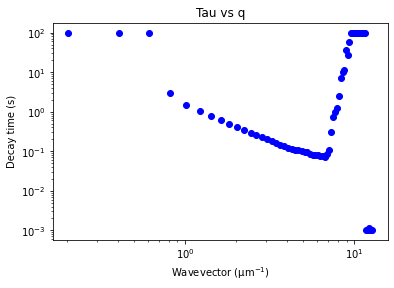

In [4]:
fig, ax = plt.subplots()
ax.loglog(wavevector_q, decaytime_tau, 'bo')
ax.set_xlabel("Wavevector (μm$^{-1}$)");
ax.set_ylabel("Decay time (s)");
ax.set_title("Tau vs q");

##############################################################
# Notice that there are clear outliers. At both low and at   #
# high values of q, it seems we are not accurately measuring #
# the decay time.                                            #
##############################################################

### Recognizing limits of our data.

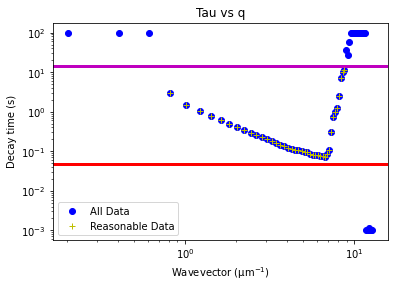

In [5]:
imaging_rate = 41.7 #we recorded the video of diffusing beads at a rate of 41.7 frames per second
long_lag_time = 600/imaging_rate #the longest lag time calculated was for a lag of 600 frames (here, converted to seconds)

fig, ax = plt.subplots()
ax.loglog(wavevector_q, decaytime_tau, 'bo', label="All Data")
ax.set_xlabel("Wavevector (μm$^{-1}$)");
ax.set_ylabel("Decay time (s)");
ax.set_title("Tau vs q");

ax.axhline(y = 2/imaging_rate, color='r', linestyle='-', linewidth=3)
ax.axhline(y = long_lag_time, color='m', linestyle='-', linewidth=3)

where_tau_is_reasonable = np.where((decaytime_tau>2/imaging_rate) & (decaytime_tau<long_lag_time))
ax.loglog(wavevector_q[where_tau_is_reasonable], decaytime_tau[where_tau_is_reasonable], 'y+', label="Reasonable Data")

plt.legend(loc=0)

####################################################################################
# If density fluctuations in our image series decay at times at the red line or    #
# below then, given our frame rate, by our first measured lag time, the            #
# fluctuations would have already decayed to 60% or less. Therefore, we are        #
# unlikely to measure accurately these fast fluctuations.                          #
# If fluctuations decay slower than times at or above the magenta line, then,      #
# given our maximum lag time, we would observe at most a decay of ~64%.            #
####################################################################################

### Fitting our data to a power law.

Often, we have dynamics that can be described by:
> $\tau = \frac{1}{Kq^p},$

where $\tau$ is the decay time, $q$ is the wavevector, $K$ is an effective diffusion coefficient, and $p$ is some power. 

In general, if $p = 2$ then we have Brownian diffusion and $K$ is equal to the diffusion coefficient. If $p = 1$, then we have ballistic motion and $K$ will be the characteristic velocity.

By taking the logarithm of the equation above, we can find $p$ and $K$ using a linear fit. That is:
> $\log{\tau} = -\log{K} - p \log{q}$

Below, we fit the above expression two different ways. Firstly, we use the [linear least-squares regression from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). Next, we use the [RANSAC regression model from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html). 

Power determined using a linear least-squares regression: 0.236
Power determined using RANSAC linear model estimation: 1.588
Value of 'K' determined using RANSAC linear model estimation: 0.752


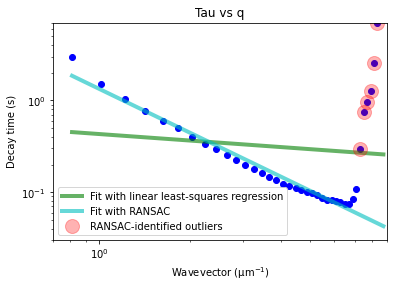

In [6]:
# We first try to use SciPy's linear least-squares regression function
fit_result = scipy.stats.linregress(np.log(wavevector_q[where_tau_is_reasonable]),np.log(decaytime_tau[where_tau_is_reasonable]))
power_p = -1*fit_result[0]
diffusion_coeff = np.exp(-1*fit_result[1])
tau_fit_linearregression = 1./(diffusion_coeff * (wavevector_q[where_tau_is_reasonable]**power_p))
print("Power determined using a linear least-squares regression: %.3f" % power_p)

# Next, we use a "robust regression" model using scikit-learn
# In particular, we use RANdom SAmple Consensus (RANSAC)
estimator = RANSACRegressor(random_state=42)
estimator.fit(np.log(wavevector_q[where_tau_is_reasonable])[:,np.newaxis],np.log(decaytime_tau[where_tau_is_reasonable]))
power_p = -1*estimator.estimator_.coef_
diffusion_coeff = np.exp(-1*estimator.estimator_.intercept_)
tau_fit_RANSAC = 1./(diffusion_coeff * (wavevector_q[where_tau_is_reasonable]**power_p))
print("Power determined using RANSAC linear model estimation: %.3f" % power_p)
print("Value of 'K' determined using RANSAC linear model estimation: %.3f" % diffusion_coeff)
inlier_mask = estimator.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

fig, ax = plt.subplots()
ax.loglog(wavevector_q, decaytime_tau, 'bo')
ax.set_xlabel("Wavevector (μm$^{-1}$)");
ax.set_ylabel("Decay time (s)");
ax.set_title("Tau vs q");

ax.plot(wavevector_q[where_tau_is_reasonable], tau_fit_linearregression, '-g', lw=4, alpha=0.6, label="Fit with linear least-squares regression")
ax.plot(wavevector_q[where_tau_is_reasonable], tau_fit_RANSAC, '-c', lw=4, alpha=0.6, label="Fit with RANSAC")
ax.plot(wavevector_q[where_tau_is_reasonable][outlier_mask], decaytime_tau[where_tau_is_reasonable][outlier_mask], linestyle='',
        marker='o', color='r', ms=14, alpha=0.3, label="RANSAC-identified outliers")

#ax.loglog(wavevector_q, 1/(wavevector_q*wavevector_q*0.6), '-k')

ax.set_ylim(0.03, 7)
ax.set_xlim(0.7,  9)

plt.legend(loc=0);